In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, LSTM, Bidirectional


ModuleNotFoundError: No module named 'numpy'

In [35]:
# Define the paths
data_paths = {
    'Bearing Fault': r'E:\Cutting Tool Paper\Dataset\cutting tool data\new_data\CWT\Bearing Fault Data',
    'Gear Fault': r'E:\Cutting Tool Paper\Dataset\cutting tool data\new_data\CWT\Gear Fault Data',
    'Tool Fault': r'E:\Cutting Tool Paper\Dataset\cutting tool data\new_data\CWT\Tool Fault Data',
    'Normal': r'E:\Cutting Tool Paper\Dataset\cutting tool data\new_data\CWT\Normal Data'
}


In [36]:
# Function to load images and labels
def load_images_and_labels(data_paths):
    images = []
    labels = []
    for label, path in data_paths.items():
        for file in os.listdir(path):
            img_path = os.path.join(path, file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(data_paths)
print(len(images))
print(len(labels))


160
160


In [37]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# One-hot encode the labels
labels_one_hot = tf.keras.utils.to_categorical(labels_encoded)


In [38]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)


In [39]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout

# Load the VGG16 model without the top layer
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG16
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
input_layer = Input(shape=(224, 224, 3))
x = vgg_base(input_layer)
x = Flatten()(x)
cnn_feature_model = Model(inputs=input_layer, outputs=x)

# Extract features for the training and validation sets
X_train_features = cnn_feature_model.predict(X_train)
X_val_features = cnn_feature_model.predict(X_val)


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [40]:
# Reshape the features to fit LSTM input requirements
X_train_features = X_train_features.reshape(X_train_features.shape[0], 1, X_train_features.shape[1])
X_val_features = X_val_features.reshape(X_val_features.shape[0], 1, X_val_features.shape[1])


In [41]:
X_train.shape, X_val.shape

((128, 224, 224, 3), (32, 224, 224, 3))

In [42]:
from tensorflow.keras.layers import LSTM

lstm_input = Input(shape=(1, X_train_features.shape[2]))
x = Bidirectional(LSTM(128))(lstm_input)
lstm_feature_model = Model(inputs=lstm_input, outputs=x)

# Extract temporal features using bidirectional LSTM
X_train_lstm_features = lstm_feature_model.predict(X_train_features)
X_val_lstm_features = lstm_feature_model.predict(X_val_features)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [10]:
from deap import base, creator, tools, algorithms
import random

# Define evaluation function
def evaluate(individual):
    selected_features = [i for i in range(len(individual)) if individual[i] == 1]
    if len(selected_features) == 0:
        return 0,
    
    X_train_selected = X_train_lstm_features[:, selected_features]
    X_val_selected = X_val_lstm_features[:, selected_features]
    
    model = tf.keras.Sequential([
        Dense(64, activation='relu', input_dim=len(selected_features)),
        Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_selected, y_train, epochs=10, batch_size=8, verbose=0)
    
    _, accuracy = model.evaluate(X_val_selected, y_val, verbose=0)
    return accuracy,

# Define GA components
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train_lstm_features.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# GA execution
population = toolbox.population(n=50)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=3, verbose=True)

# Get the best individual
best_ind = tools.selBest(population, k=1)[0]
selected_features = [i for i in range(len(best_ind)) if best_ind[i] == 1]


C:\Users\Muhammad Umar\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


gen	nevals
0  	50    
1  	31    
2  	26    
3  	27    


In [48]:
# Select the features based on GA
X_train_selected = X_train_lstm_features[:, selected_features]
X_val_selected = X_val_lstm_features[:, selected_features]

# Define the final classification model
final_model = tf.keras.Sequential([
    Dense(64, activation='relu', input_dim=len(selected_features)),
    Dense(4, activation='softmax')
])

final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the final model
history = final_model.fit(X_train_selected, y_train, epochs=5, batch_size=8, validation_data=(X_val_selected, y_val))


Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3515 - loss: 1.3066 - val_accuracy: 0.9062 - val_loss: 0.9395
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9657 - loss: 0.8197 - val_accuracy: 1.0000 - val_loss: 0.5817
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.4750 - val_accuracy: 1.0000 - val_loss: 0.3325
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.2856 - val_accuracy: 1.0000 - val_loss: 0.1844
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1786 - val_accuracy: 1.0000 - val_loss: 0.1133


In [44]:
# Evaluate the model on the validation set
val_loss, val_accuracy = final_model.evaluate(X_val_selected, y_val)
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 9.2558e-05
Validation Accuracy: 100.00%


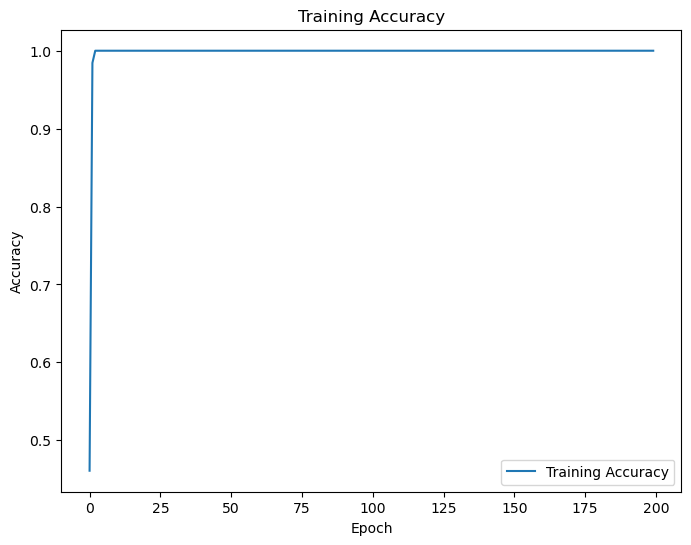

In [45]:
import matplotlib.pyplot as plt

# Get training accuracy values
acc = history.history['accuracy']

# Plot training accuracy
plt.figure(figsize=(8, 6))
plt.plot(acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


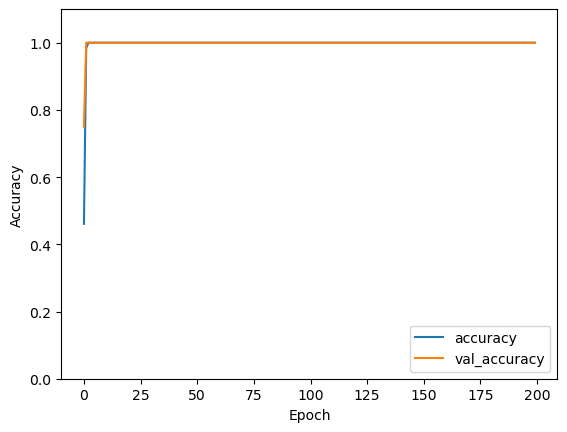

In [46]:
# Plot and save accuracy
plt.plot(history.epoch,history.history['accuracy'], label='accuracy')
plt.plot(history.epoch,history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.1])
plt.legend(loc='lower right') 

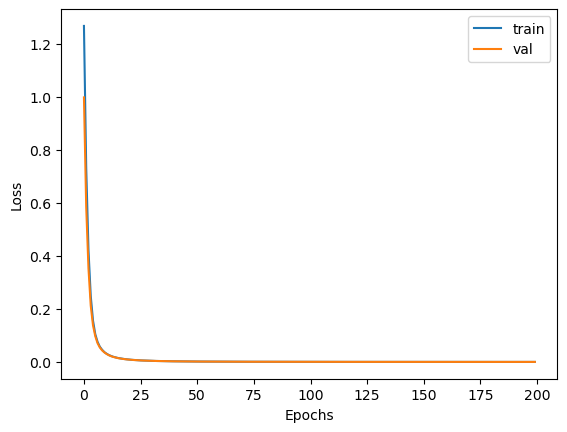

In [47]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


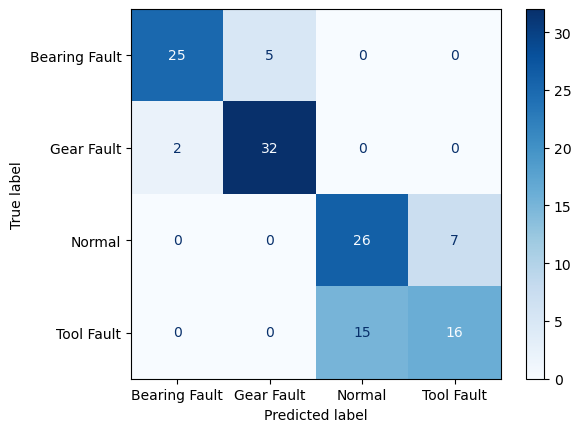

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for the training data
y_train_pred = final_model.predict(X_train_selected)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_train_true_classes, y_train_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
#plt.title('Confusion Matrix - Training Data')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


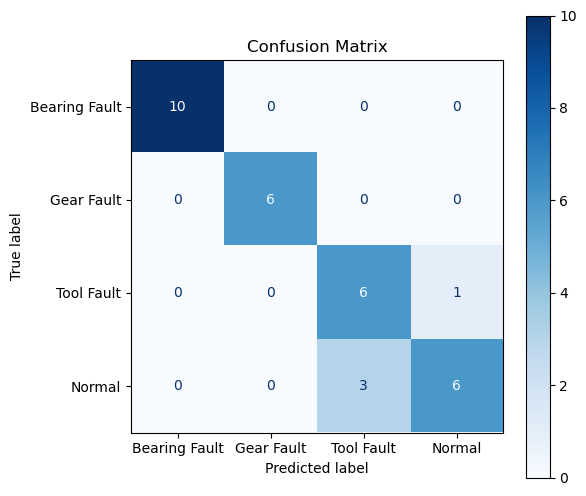

In [17]:
# Plot confusion matrix
y_val_pred = final_model.predict(X_val_selected)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(data_paths.keys()))
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

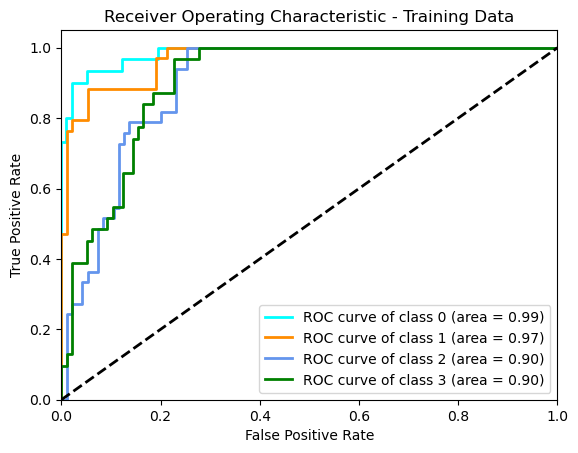

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
y_train_binarized = label_binarize(y_train_true_classes, classes=[0, 1, 2, 3])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_train.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_train_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Training Data')
plt.legend(loc="lower right")
plt.show()


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


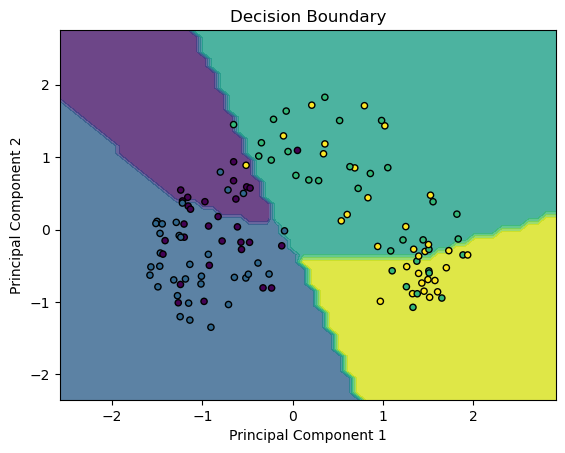

In [19]:
from sklearn.decomposition import PCA

# Reduce features to 2D using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_selected)

# Plot decision boundaries
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Create a mesh to plot points in
Z = final_model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_true_classes, edgecolor='k', s=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary')
plt.show()


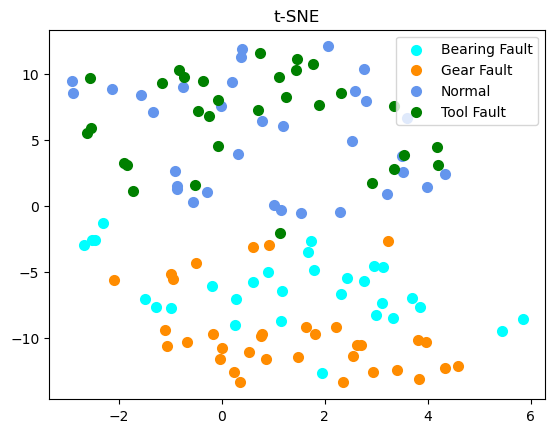

In [20]:
from sklearn.manifold import TSNE

# Reduce features to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_selected)

# Plot t-SNE
plt.figure()
for i, color, label in zip(range(n_classes), colors, label_encoder.classes_):
    plt.scatter(X_train_tsne[y_train_true_classes == i, 0], X_train_tsne[y_train_true_classes == i, 1], color=color, lw=2, label=label)
plt.title('t-SNE')
plt.legend(loc='best')
plt.show()


In [21]:
from collections import Counter
print(Counter(labels))


Counter({'Bearing Fault': 40, 'Gear Fault': 40, 'Tool Fault': 40, 'Normal': 40})


In [23]:
from sklearn.metrics import classification_report
# Generate classification report
train_report = classification_report(y_train_true_classes, y_train_pred_classes, target_names=label_encoder.classes_)
print(train_report)

               precision    recall  f1-score   support

Bearing Fault       0.93      0.83      0.88        30
   Gear Fault       0.86      0.94      0.90        34
       Normal       0.63      0.79      0.70        33
   Tool Fault       0.70      0.52      0.59        31

     accuracy                           0.77       128
    macro avg       0.78      0.77      0.77       128
 weighted avg       0.78      0.77      0.77       128

